In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df.reset_index(drop=True)
    
    return concat_df

In [6]:
yunrip_df = data_prep('연립다세대', '매매')
print(yunrip_df.shape)
yunrip_df.head()

16it [00:02,  6.17it/s]


(688568, 12)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 1264-3,개포로31길 23-7,(1264-3),53.28,29.23,11500,-1,1992.0,14.0,2006-08-29,215.840841,29.0
1,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
3,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
4,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0


In [7]:
officetel_df = data_prep('오피스텔', '매매')
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 23.66it/s]


(178440, 11)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [8]:
def land_shape2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '사다리' in x:
            return '사다리형'
        elif '장방' in x:
            return '장방형'
        elif '정방' in x:
            return '정방형'
        elif '부정' in x:
            return '부정형'
        elif '않음' in x:
            return '지정되지않음'
        elif '자루' in x:
            return '자루형'
        elif '삼각' in x:
            return '삼각형'
        else:
            return '기타'

In [9]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
land_specs_df['지형형상2'] = land_specs_df['지형형상'].apply(land_shape2)
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 12)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가,지형형상2
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0,부정형
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0,부정형
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0,부정형
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0,부정형
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0,부정형


In [10]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,부정형
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지,부정형
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지,부정형


In [12]:
yunrip_merge_df = yunrip_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
officetel_merge_df = officetel_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [13]:
yunrip_df['구'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_df['동'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[2])
yunrip_merge_df['구'] = yunrip_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_merge_df['동'] = yunrip_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])
officetel_df['구'] = officetel_df['지번주소'].apply(lambda x: x.split(' ')[1])
officetel_df['동'] = officetel_df['지번주소'].apply(lambda x: x.split(' ')[2])
officetel_merge_df['구'] = officetel_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
officetel_merge_df['동'] = officetel_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [46]:
target_gu = '구로구'
target_dong = '고척동'
target_purpose = '준공업'

In [15]:
target_df = yunrip_merge_df[
    (yunrip_merge_df['구'] == target_gu)
    &(yunrip_merge_df['동'] == target_dong)
    &(yunrip_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(yunrip_merge_df['건물연식'] <= 4)
    #&(yunrip_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(208, 23)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
105443,서울특별시 구로구 고척동 249-117,고척로31길 84,계림트라움,28.36,20.23,17800,5,2018.0,2.0,2020-02-27,627.644570,3.0,대,383.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,구로구,고척동
105444,서울특별시 구로구 고척동 249-117,고척로31길 84,계림트라움,45.77,32.65,24000,3,2018.0,2.0,2020-03-27,524.360935,3.0,대,383.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,구로구,고척동
105445,서울특별시 구로구 고척동 249-117,고척로31길 84,계림트라움,46.83,33.41,24000,5,2018.0,2.0,2020-05-23,512.491992,3.0,대,383.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,구로구,고척동
105446,서울특별시 구로구 고척동 249-117,고척로31길 84,계림트라움,45.77,32.65,24000,3,2018.0,2.0,2020-12-14,524.360935,3.0,대,383.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,구로구,고척동
636623,서울특별시 구로구 고척동 250-7,고척로33길 104,로뎀하우스,29.92,19.82,16400,2,2017.0,2.0,2019-10-31,548.128342,4.0,대,230.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,세로한면(가),사다리형,구로구,고척동


In [77]:
target_df2 = officetel_merge_df[
    (officetel_merge_df['구'] == target_gu)
    &(officetel_merge_df['동'] == target_dong)
    &(officetel_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    #&(officetel_merge_df['건물연식'] <= 4)
    #&(officetel_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(3, 22)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
32515,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,32000,7,2006.0,13.0,2019-12-27,366.007091,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동
32516,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,34800,7,2006.0,14.0,2020-03-18,398.032712,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동
32517,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,32500,2,2006.0,14.0,2020-04-02,371.725952,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동


In [71]:
target_df2

,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
32512,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,29500,11,2006.0,13.0,2019-07-16,337.412787,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동
32513,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,30500,7,2006.0,13.0,2019-09-21,348.850509,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동
32514,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,29500,5,2006.0,13.0,2019-10-22,337.412787,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동
32515,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,32000,7,2006.0,13.0,2019-12-27,366.007091,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동
32516,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,34800,7,2006.0,14.0,2020-03-18,398.032712,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동
32517,서울특별시 구로구 고척동 76-38,경인로 403,원메디타운,87.43,32500,2,2006.0,14.0,2020-04-02,371.725952,15.0,대,1890.0,준공업지역,지정되지않음,업무용,평지,사다리형,광대소각,사다리형,구로구,고척동


In [74]:
target_df3 = yunrip_merge_df[
    (yunrip_merge_df['구'] == target_gu)
    &(yunrip_merge_df['동'] == target_dong)
    &(yunrip_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(yunrip_merge_df['건물연식'] <= 17)
    &(yunrip_merge_df['건물연식'] >= 13)
    #&(yunrip_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df3.shape)
target_df3.head()

(13, 23)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
105345,서울특별시 구로구 고척동 241-129,고척로33길 60,(241-129),46.36,19.77,16500,2,2006.0,14.0,2020-11-14,355.910267,15.0,대,212.0,제2종일반주거지역,지정되지않음,주상용,완경사,세로장방,세로각지(가),장방형,구로구,고척동
105346,서울특별시 구로구 고척동 241-129,고척로33길 60,(241-129),46.36,19.78,17500,4,2006.0,14.0,2020-12-30,377.480587,15.0,대,212.0,제2종일반주거지역,지정되지않음,주상용,완경사,세로장방,세로각지(가),장방형,구로구,고척동
105507,서울특별시 구로구 고척동 249-18,고척로33길 47,금강주택,44.44,18.62,13500,4,2005.0,14.0,2019-11-07,303.780378,16.0,대,221.0,제2종일반주거지역,지정되지않음,주상기타,완경사,정방형,세로각지(가),정방형,구로구,고척동
105508,서울특별시 구로구 고척동 249-18,고척로33길 47,금강주택,57.44,24.06,18500,4,2005.0,15.0,2020-02-12,322.075209,16.0,대,221.0,제2종일반주거지역,지정되지않음,주상기타,완경사,정방형,세로각지(가),정방형,구로구,고척동
349346,서울특별시 구로구 고척동 253-19,고척로27가길 21,브라운스톤 5차,57.36,33.44,22950,3,2007.0,13.0,2020-12-09,400.104603,14.0,대,241.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,구로구,고척동


In [75]:
target_df2['단가(만원/㎡)'].describe()

count      6.000000
mean     359.906973
std       23.514650
min      337.412787
25%      340.272218
50%      357.428800
75%      370.296237
max      398.032712
Name: 단가(만원/㎡), dtype: float64

In [76]:
target_df3['단가(만원/㎡)'].describe()

count     13.000000
mean     341.699241
std       63.357621
min      207.237366
25%      307.160683
50%      345.555769
75%      355.910267
max      484.864720
Name: 단가(만원/㎡), dtype: float64

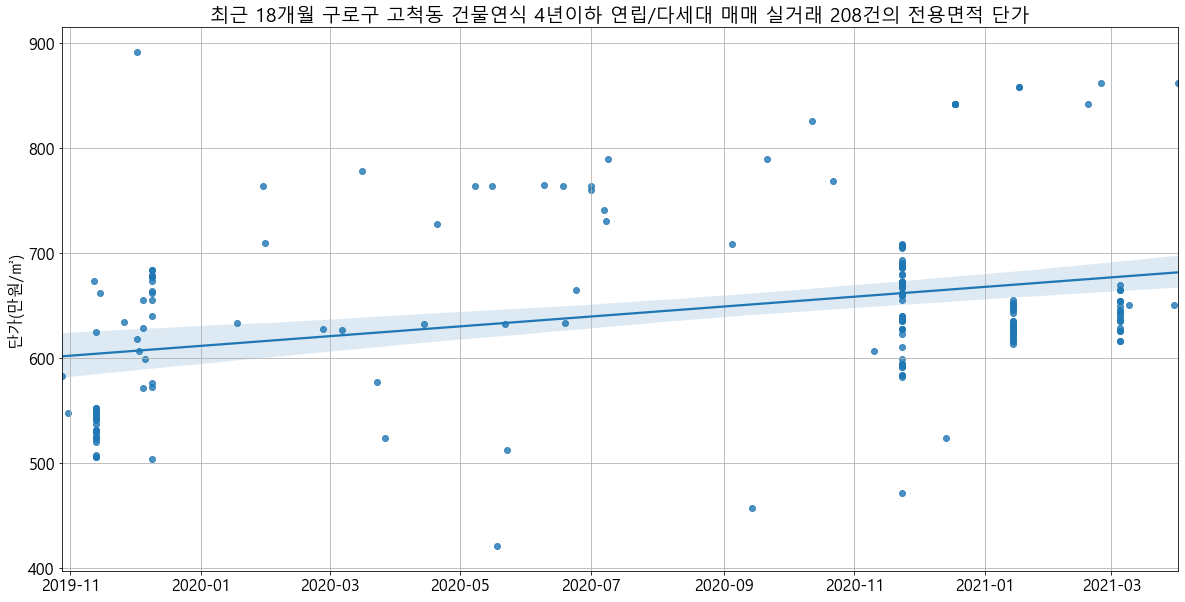

In [78]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 18개월 {} {} 건물연식 4년이하 연립다세대 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/연립다세대_산포도.png'.format(target_gu, target_dong))

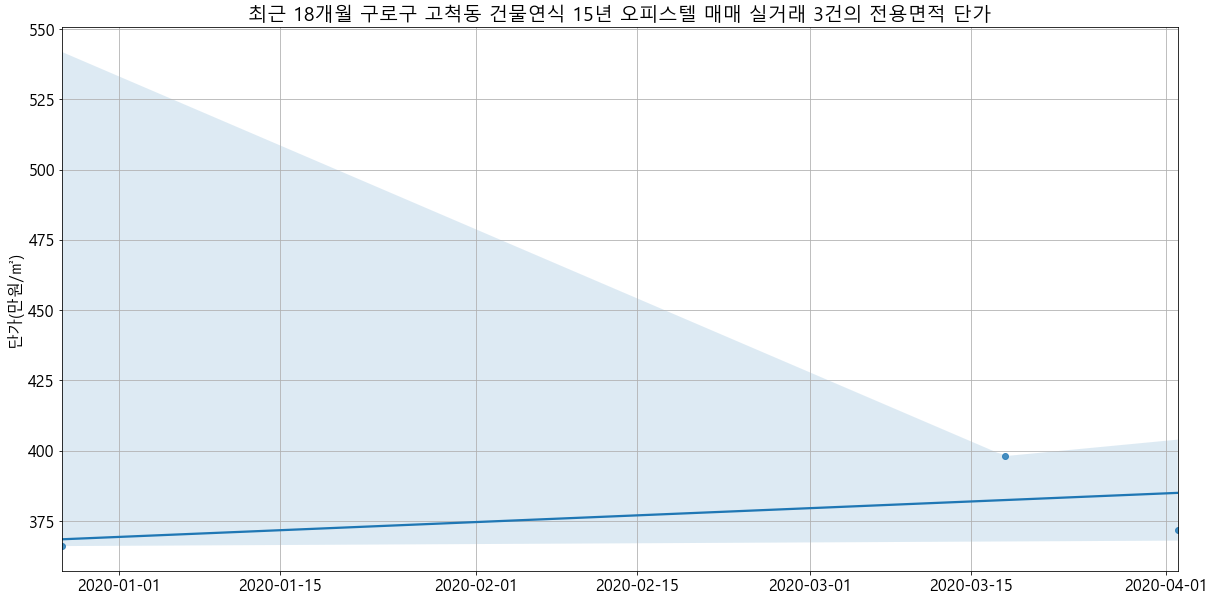

In [85]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 18개월 {} {} 건물연식 15년 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_df2.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df2['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df2['계약날짜']), y=target_df2['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/오피스텔_건물연식15년_산포도.png'.format(target_gu, target_dong))

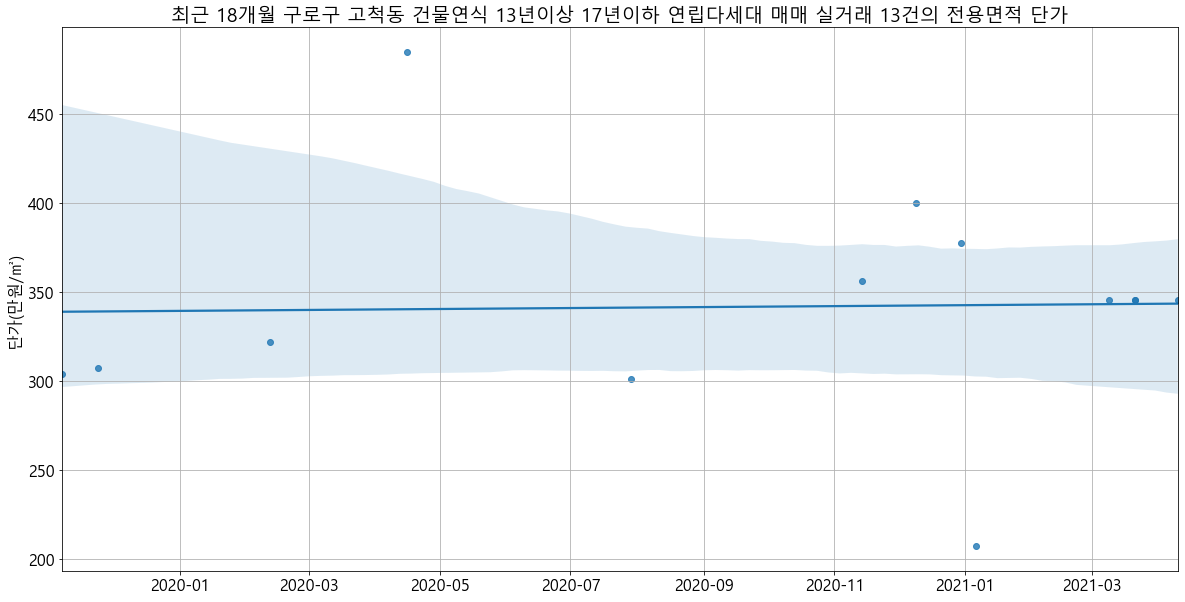

In [86]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 18개월 {} {} 건물연식 13년이상 17년이하 연립다세대 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_df3.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df3['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df3['계약날짜']), y=target_df3['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/연립다세대_건물연식_13년이상_17년이하_산포도.png'.format(target_gu, target_dong))

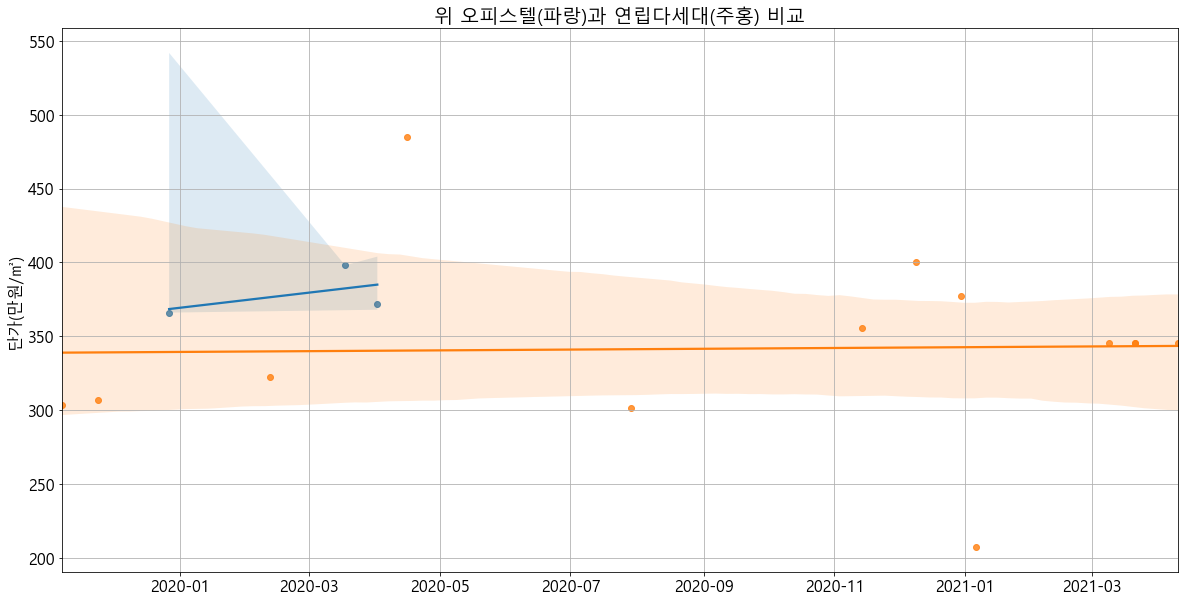

In [87]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('위 오피스텔(파랑)과 연립다세대(주홍) 비교'.format(target_gu, target_dong, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df2['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df2['계약날짜']), y=target_df2['단가(만원/㎡)'])
ax.xaxis.update_units(target_df3['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df3['계약날짜']), y=target_df3['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/오피스텔_연립다세대_비교_산포도.png'.format(target_gu, target_dong))

In [88]:
concat_df = pd.concat([target_df])

In [89]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [90]:
selected_df = concat_df[['지번주소', '건물명', '건축년도', '단가평균', '용도지역명1']].drop_duplicates()
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)
print(selected_df.shape)
selected_df.head()

(20, 5)


,지번주소,건물명,건축년도,단가평균,용도지역명1
0,서울특별시 구로구 고척동 145-96,수명그린빌(145-96),2018.0,891.938250,제2종일반주거지역
1,서울특별시 구로구 고척동 161-8,하이원팰리스,2017.0,614.122638,제2종일반주거지역
2,서울특별시 구로구 고척동 164-114,우영채움빌,2017.0,655.579658,제2종일반주거지역
3,서울특별시 구로구 고척동 165-18,고척 헤리츠,2019.0,826.407029,제2종일반주거지역
4,서울특별시 구로구 고척동 171-1,더플러스2,2020.0,656.011492,제3종일반주거지역


In [91]:
selected_df

,지번주소,건물명,건축년도,단가평균,용도지역명1
0,서울특별시 구로구 고척동 145-96,수명그린빌(145-96),2018.0,891.938250,제2종일반주거지역
1,서울특별시 구로구 고척동 161-8,하이원팰리스,2017.0,614.122638,제2종일반주거지역
2,서울특별시 구로구 고척동 164-114,우영채움빌,2017.0,655.579658,제2종일반주거지역
3,서울특별시 구로구 고척동 165-18,고척 헤리츠,2019.0,826.407029,제2종일반주거지역
4,서울특별시 구로구 고척동 171-1,더플러스2,2020.0,656.011492,제3종일반주거지역
5,서울특별시 구로구 고척동 171-13,더플러스1,2020.0,655.701238,제3종일반주거지역
6,서울특별시 구로구 고척동 241-162,뜰안에,2017.0,695.520159,제2종일반주거지역
7,서울특별시 구로구 고척동 241-84,하늘사랑채에이동,2021.0,631.714095,제2종일반주거지역
8,서울특별시 구로구 고척동 241-88,하늘사랑채비동,2021.0,653.961519,제2종일반주거지역
9,서울특별시 구로구 고척동 249-117,계림트라움,2018.0,547.214608,제2종일반주거지역


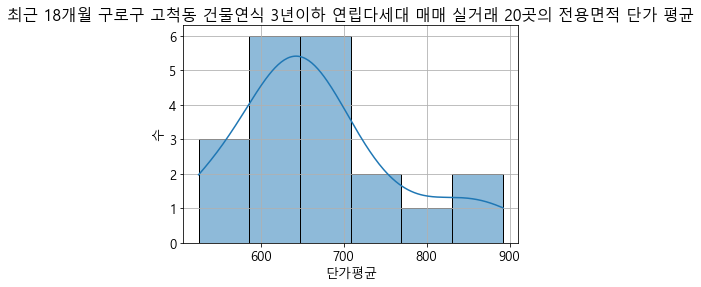

<Figure size 432x288 with 0 Axes>

In [92]:
font = {'size': 13}
matplotlib.rc('font', **font)
plt.grid(True)
plt.ylabel('수')
plt.title('최근 18개월 {} {} 건물연식 3년이하 연립다세대 매매 실거래 {}곳의 전용면적 단가 평균'.format(target_gu, target_dong, selected_df.shape[0]))
sns.histplot(selected_df['단가평균'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/분포도.png'.format(target_gu, target_dong))
plt.show()
plt.clf()

In [93]:
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)

In [94]:
selected_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/실거래가.xlsx'.format(target_gu, target_dong), index=False)